In [3]:
import cv2
import numpy as np
from tqdm import trange
from flygym import Fly, Simulation, Camera, get_data_path
from flygym.arena import FlatTerrain
from flygym.preprogrammed import all_leg_dofs
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
import sys
#sys.path.append('C:/Users/laeti/Documents/laetitia/EPFL/Master/CoursMA2/Control_Behaviour/projet')
from hybrid_turning_fly import HybridTurningFly
from simulation_CPG import Simulation_CPG
from flygym.examples.cpg_controller import CPGNetwork
from IPython import display
from flygym.vision import save_video_with_vision_insets

In [4]:
from flygym import Parameters, NeuroMechFly
nmf = NeuroMechFly(Parameters(enable_adhesion=True, draw_adhesion=True))
from flygym.examples.common import PreprogrammedSteps

#Filtering initialization :
import numpy as np
from collections import deque

preprogrammed_steps = PreprogrammedSteps()
swing_periods = preprogrammed_steps.swing_period
legs = preprogrammed_steps.legs

c:\users\laeti\documents\laetitia\epfl\master\coursma2\control_behaviour\projet\flygym-v1\flygym\core.py:331: UserWarning: Deprecation warning: The `NeuroMechFly` class has been restructured into `Simulation`, `Fly`, and `Camera`.`NeuroMechFly` will be removed in future versions.
  warnings.warn(


In [5]:
class VisualTaxisFly(HybridTurningFly):
    def __init__(self, obj_threshold=0.15, decision_interval=0.05, **kwargs):
        super().__init__(**kwargs, enable_vision=True)
        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / self.timestep)
        self.visual_inputs_hist = []

        self.coms = np.empty((self.retina.num_ommatidia_per_eye, 2))

        for i in range(self.retina.num_ommatidia_per_eye):
            mask = self.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

    def process_visual_observation(self, vision_input):
        features = np.zeros((2, 3))

        for i, ommatidia_readings in enumerate(vision_input):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj_coords = self.coms[is_obj]

            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)

            features[i, 2] = is_obj_coords.shape[0]

        features[:, 0] /= self.retina.nrows  # normalize y_center
        features[:, 1] /= self.retina.ncols  # normalize x_center
        features[:, 2] /= self.retina.num_ommatidia_per_eye  # normalize area
        return features.ravel().astype("float32")

    @staticmethod
    def calc_ipsilateral_speed(deviation, is_found):
        if not is_found:
            return 1.0
        else:
            return np.clip(1 - deviation * 3, 0.4, 1.2)

In [ ]:
class MovingFly(Fly):
    def __init__(self, init_pose="stretch", actuated_joints=None, control="position",
                 initial_position=None, initial_orientation=None, **kwargs):
        super().__init__(**kwargs, init_pose=init_pose, actuated_joints=actuated_joints, control=control,
                         spawn_pos=initial_position, spawn_orientation=initial_orientation, enable_vision=True)
        self.visual_inputs_hist = []
        self.standing=[] #joints angles to stand
        self.strech=[] #linespace to strech the elg
        self.middle_stance_ids=[] #je sais pas a quoi ca sert
        self.mid_leg_end_effector=[] #init des end effector
        self.joint_record=[] #init des end effector

    def simulate_step(self, sim: Simulation, roll_angle: float, yaw_angle: float, side: str='L'):
        action = {"joints": self.simulate_movement(sim, roll_angle, yaw_angle, side)}
        action["adhesion"] = np.array([1,0,1,1,0,1]) #add adhesion 
        return action

    def simulate_movement(self, sim: Simulation, roll_angle: float, yaw_angle: float, side: str, increment: float = 0.00015,):
        joint_pos = self.standing.copy()

        joint_angles = preprogrammed_steps.get_joint_angles("LM" if side == "L" else "RM", 0)

        if side == "L":
            joint_pos[7:14] = joint_angles + self.strech
            joint_pos[9], joint_pos[7] = roll_angle, yaw_angle  # Setting specific yaw and pitch
        else:
            joint_pos[28:35] = joint_angles + self.strech
            joint_pos[30], joint_pos[28] = roll_angle, yaw_angle

        #print(joint_pos[28:35])
        self.record_mov(sim, side, joint_pos)
        return joint_pos

    def record_mov(self, sim: Simulation, side: str, joint_pos):
        observation = self.get_observation(sim)
        end_effector = observation["end_effectors"]
        if side=='L': self.mid_leg_end_effector.append([end_effector[1,:]])
        else : self.mid_leg_end_effector.append([end_effector[3,:]])
        
        self.joint_record.append(joint_pos)




: 

In [ ]:
def scenario(start_postion=0):
    pos = (0,4.5,0)
    orien_fwd = (0,0,np.pi/2)
    orien_bcd =(0,0,-np.pi/2)

    match start_postion:
        case 0 : return pos, orien_fwd
        case 1:
            pos = (16,4.5,0)
            return pos, orien_bcd
        case 2:
            pos = (16,-4.5,0)
            return pos, orien_bcd
        case 3 :
            return (0,-5,0), orien_fwd
        case TypeError:
            print("wrong start_position, default values taken")
            return pos, orien_fwd

In [ ]:
timestep = 1e-4
scenario_fly1=3

fly = Fly(
    name="1",
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    draw_adhesion=False,
    spawn_pos= scenario(scenario_fly1)[0],
    spawn_orientation = scenario(scenario_fly1)[1]
)

#need to process visual informations
# fly0 = VisualTaxisFly(
#     name="0", #static
#     timestep=timestep,
#     enable_adhesion=True,
#     head_stabilization_model="thorax",
#     neck_kp=1000,
#     spawn_pos=(8,0,0), #position
#     spawn_orientation = (0,0,-np.pi/2)
# )

fly0 = MovingFly(

    name="0", #static
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
    initial_position=(8,0,0), #position
    initial_orientation = (0,0,-np.pi/2)
)


arena = FlatTerrain()

birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(600, 400),
)

# sim = Simulation(
#     flies=[fly0, fly],
#     cameras=[cam],
#     arena=arena,
#     timestep=timestep,
# )

cam1 = Camera(fly=fly0, play_speed=0.2, draw_contacts=False, camera_follows_fly_orientation=True)

sim = Simulation(
    flies=[fly0, fly],
    cameras=[cam1, cam],
    arena=arena,
    timestep=timestep,
)

simulation_cpg = Simulation_CPG(timestep)

In [ ]:
########################## Vision Model definition ###############################
#to see the training -> vision.ipynb

from utils import crop_hex_to_rect

import torch
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Define your layers here
        self.conv1 = nn.Conv2d(2, 8, 3, groups=2)  # Convolutional layer
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, groups=2)  # Convolutional layer
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 8, 3, groups=2)  # Convolutional layer
        self.pool3 = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.fc1 = nn.LazyLinear(16)  # Lazy linear layer
        self.fc2 = nn.Linear(16, 16)  # Linear layer
        self.fc3 = nn.Linear(16, 2)   # Linear layer for output

    def forward(self, x):
        # Define the forward pass
        x = F.tanh(self.conv1(x))
        x = F.relu(self.bn1(x))
        x = F.tanh(self.conv2(x))
        x = self.bn2(x)  # Apply pooling after the second convolution
        x = F.tanh(self.conv3(x))
        x = self.pool3(x)  # Apply pooling after the third convolution
        x = x.flatten(1)   # Flatten the output to feed into linear layers
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Create an instance of the model
model = Model()

# Load the model weights
model.load_state_dict(torch.load('./best_model/best_model_vision.pth'))

model.eval()


c:\Users\laeti\anaconda3\envs\flygym-v1\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
########################## Initialization ###############################

run_time = 1
obs, info = sim.reset(seed=0)

for i in fly.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

second_cam_frames = []
x = None
alpha = 1e-1


#usefull constant
target_num_steps=1000 #0.3/0.001 enginner joint angles

middle_stance_ids = np.linspace(swing_periods["RM"][1], 2 * np.pi, target_num_steps)



roll_finished = False
movement_roll=False
i_roll=0

########################## Filtering ###############################
n = 50  # Number of observations for moving average
theta_pred_history = deque(maxlen=n)
distances_history = deque(maxlen=n)


########################## Standing behaviour ###############################
standing_action = []
for leg in legs:
    if leg.endswith("M"):
        standing_action.extend(
            preprogrammed_steps.get_joint_angles(leg, swing_periods[leg][1])
        )
    else:
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

fly0_action = {"joints": standing_action, "adhesion": np.array([1,0,1,1,0,1])}
fly0.standing= standing_action
real_angle=0

In [ ]:
yam_history = []
distances_sma_hist = []
theta_pred_sma_hist=[]
real_angle_hist=[]
Start_record = True

start_id =0


run_time=1

distance_cond = False

for t in trange(int(run_time / sim.timestep)):
    fly1_action = simulation_cpg.update(fly.actuated_joints)
    obs, _,_ ,_ , info = sim.step({
        "0" : fly0_action,
        "1" : fly1_action,
    })

    obs0, info0 = obs["0"], info["0"]
    fly0.obs = obs0
    render_res = sim.render()[0]

    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)
        

    ########################## NN Vision based on week 4 ###############################
        
    imgs = crop_hex_to_rect(obs0["vision"]) #transform the image into a rectangle by croping
    imgs = np.expand_dims(imgs, axis=0) #transform into a 4d vector to match the training data

    with torch.no_grad(): #gradient doesn't flow back in the model
        coords_lr_pred = model(torch.tensor(imgs)).numpy()

    #prediction of the other fly's position
    theta_pred = np.angle(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))
    distances = np.linalg.norm(coords_lr_pred, axis=1)
    ########################## Filtering ####################################
    #Moving average
    theta_pred_history.append(theta_pred)
    distances_history.append(distances)

    theta_pred_sma = np.mean(theta_pred_history)
    distances_sma = np.mean(distances_history)

    distances_sma_hist.append(distances_sma)
    theta_pred_sma_hist.append(theta_pred_sma)


    ########################## Workspace transcription ###############################
    #a verifier mais pas sur du tout
    if theta_pred_sma < 0:
        side='R'
        real_angle = -(theta_pred_sma + np.deg2rad(90)) #offset on the leg actuator
    else:
        side='L'
        #real_angle = -(theta_pred_sma + np.deg2rad(90)) #offset on the leg actuator
        #real_angle= - theta_pred_sma + np.deg2rad(90)
        real_angle= theta_pred_sma - np.deg2rad(90)

    real_angle_hist.append(real_angle)


    ########################## Movement computation ###############################


   
    if distances_sma<=8 or distance_cond :
        if not distance_cond : start_id = t
        distance_cond = True
        if movement_roll== False: #find roll to give to the fly
            L_midleg_start = preprogrammed_steps.get_joint_angles("LM", 0.0)
            L_midleg_stretch = np.linspace(np.zeros(len(L_midleg_start)), -L_midleg_start, target_num_steps)

            R_midleg_start = preprogrammed_steps.get_joint_angles("RM", 0.0)
            R_midleg_stretch = np.linspace( np.zeros(len(R_midleg_start)), -R_midleg_start, target_num_steps)

            if side=='L':
                roll_lin= np.linspace(obs0["joints"][0][9], 1.5, target_num_steps)
            else : 
                roll_lin= np.linspace(obs0["joints"][0][30], -1.5, target_num_steps)
            movement_roll=True
            previous_angle = real_angle #init
        
        

        if roll_finished:
            if side=='L':
                roll=1.5
                fly0.strech=-L_midleg_start
            else: 
                roll=-1.5
                fly0.strech=-R_midleg_start
        else:
            roll = roll_lin[i_roll]   #once finished, stay at 1.5
            if side=='L':
                fly0.strech=L_midleg_stretch[i_roll]
            else: 
                fly0.strech=R_midleg_stretch[i_roll]



        if abs(previous_angle-real_angle)<10: use_angle = real_angle
        else : use_angle = previous_angle
        previous_angle = use_angle
        if i_roll==0: #if iterations is 0 modulo target_num_steps -> compute the new order to smooth out the movement
            if side=='L':
                joint_value = obs0["joints"][0][7]
                #use_angle-= np.deg2rad(90)
                yaw_lin = np.linspace(joint_value, use_angle, target_num_steps)            

            else : 
                joint_value = obs0["joints"][0][28]
                yaw_lin = np.linspace(joint_value, use_angle, target_num_steps)
            
        yam_history.append(obs0["joints"][0][7])

        fly0.middle_stance_ids=middle_stance_ids[i_roll]
        #print(roll)
        fly0_action = fly0.simulate_step(sim, roll_angle=roll, yaw_angle=yaw_lin[i_roll], side=side) #action to follow the intruder 

        #update i roll and check if the movement is finished
        i_roll+=1
        if i_roll % target_num_steps == 0 : 
            roll_finished=True
            i_roll=0

    #compute the case where the fly is not in the range anymore -> linespace roll a l'envers et linespace vers 0 pour yaw

    ########################## If no detection ###############################
    else:
        fly0_action = {"joints": standing_action, "adhesion": np.array([1,0,1,1,0,1])} #the fly stay still

    previous_distances_sma = distances_sma

    
cam.save_video("./outputs/main_0.mp4", 0)
cam1.save_video("./outputs/main_1.mp4")

100%|██████████| 10000/10000 [06:24<00:00, 26.00it/s]


In [ ]:
yam_history = []
distances_sma_hist = []
theta_pred_sma_hist=[]
real_angle_hist=[]
Start_record = True

start_id =0


run_time=1

distance_cond = False

for t in trange(int(run_time / sim.timestep)):
    fly1_action = simulation_cpg.update(fly.actuated_joints)
    obs, _,_ ,_ , info = sim.step({
        "0" : fly0_action,
        "1" : fly1_action,
    })

    obs0, info0 = obs["0"], info["0"]
    fly0.obs = obs0
    render_res = sim.render()[0]

    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)
        

    ########################## NN Vision based on week 4 ###############################
        
    imgs = crop_hex_to_rect(obs0["vision"]) #transform the image into a rectangle by croping
    imgs = np.expand_dims(imgs, axis=0) #transform into a 4d vector to match the training data

    with torch.no_grad(): #gradient doesn't flow back in the model
        coords_lr_pred = model(torch.tensor(imgs)).numpy()

    #prediction of the other fly's position
    theta_pred = np.angle(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))
    distances = np.linalg.norm(coords_lr_pred, axis=1)
    ########################## Filtering ####################################
    #Moving average
    theta_pred_history.append(theta_pred)
    distances_history.append(distances)

    theta_pred_sma = np.mean(theta_pred_history)
    distances_sma = np.mean(distances_history)

    distances_sma_hist.append(distances_sma)
    theta_pred_sma_hist.append(theta_pred_sma)


    ########################## Workspace transcription ###############################
    #a verifier mais pas sur du tout
    if theta_pred_sma < 0:
        side='R'
        real_angle = -(theta_pred_sma + np.deg2rad(90)) #offset on the leg actuator
    else:
        side='L'
        #real_angle = -(theta_pred_sma + np.deg2rad(90)) #offset on the leg actuator
        #real_angle= - theta_pred_sma + np.deg2rad(90)
        real_angle= theta_pred_sma - np.deg2rad(90)

    real_angle_hist.append(real_angle)


    ########################## Movement computation ###############################


   
    if distances_sma<=8 or distance_cond :
        if not distance_cond : start_id = t
        distance_cond = True
        if movement_roll== False: #find roll to give to the fly
            L_midleg_start = preprogrammed_steps.get_joint_angles("LM", 0.0)
            L_midleg_stretch = np.linspace(np.zeros(len(L_midleg_start)), -L_midleg_start, target_num_steps)

            R_midleg_start = preprogrammed_steps.get_joint_angles("RM", 0.0)
            R_midleg_stretch = np.linspace( np.zeros(len(R_midleg_start)), -R_midleg_start, target_num_steps)

            if side=='L':
                roll_lin= np.linspace(obs0["joints"][0][9], 1.5, target_num_steps)
            else : 
                roll_lin= np.linspace(obs0["joints"][0][30], -1.5, target_num_steps)
            movement_roll=True
            previous_angle = real_angle #init
        
        

        if roll_finished:
            if side=='L':
                roll=1.5
                fly0.strech=-L_midleg_start
            else: 
                roll=-1.5
                fly0.strech=-R_midleg_start
        else:
            roll = roll_lin[i_roll]   #once finished, stay at 1.5
            if side=='L':
                fly0.strech=L_midleg_stretch[i_roll]
            else: 
                fly0.strech=R_midleg_stretch[i_roll]



        if abs(previous_angle-real_angle)<10: use_angle = real_angle
        else : use_angle = previous_angle
        previous_angle = use_angle
        if i_roll==0: #if iterations is 0 modulo target_num_steps -> compute the new order to smooth out the movement
            if side=='L':
                joint_value = obs0["joints"][0][7]
                #use_angle-= np.deg2rad(90)
                yaw_lin = np.linspace(joint_value, use_angle, target_num_steps)            

            else : 
                joint_value = obs0["joints"][0][28]
                yaw_lin = np.linspace(joint_value, use_angle, target_num_steps)
            
        yam_history.append(obs0["joints"][0][7])

        fly0.middle_stance_ids=middle_stance_ids[i_roll]
        #print(roll)
        fly0_action = fly0.simulate_step(sim, roll_angle=roll, yaw_angle=yaw_lin[i_roll], side=side) #action to follow the intruder 

        #update i roll and check if the movement is finished
        i_roll+=1
        if i_roll % target_num_steps == 0 : 
            roll_finished=True
            i_roll=0

    #compute the case where the fly is not in the range anymore -> linespace roll a l'envers et linespace vers 0 pour yaw

    ########################## If no detection ###############################
    else:
        fly0_action = {"joints": standing_action, "adhesion": np.array([1,0,1,1,0,1])} #the fly stay still

    previous_distances_sma = distances_sma

    
cam.save_video("./outputs/main_0.mp4", 0)
cam1.save_video("./outputs/main_1.mp4")

100%|██████████| 10000/10000 [06:24<00:00, 26.00it/s]


In [ ]:
start_id

2673

In [ ]:
cam.save_video("./outputs/jambe_gauchev1.mp4", 0)

display.Video("./outputs/jambe_gauchev1.mp4")

In [ ]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames

In [ ]:
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/fly_following_with_retina_images.mp4",
    fly0.visual_inputs_hist,
)

In [ ]:
display.Video("./outputs/fly_following_with_retina_images.mp4")

In [ ]:
display.Video("./outputs/kinematic_B_replay1.mp4")

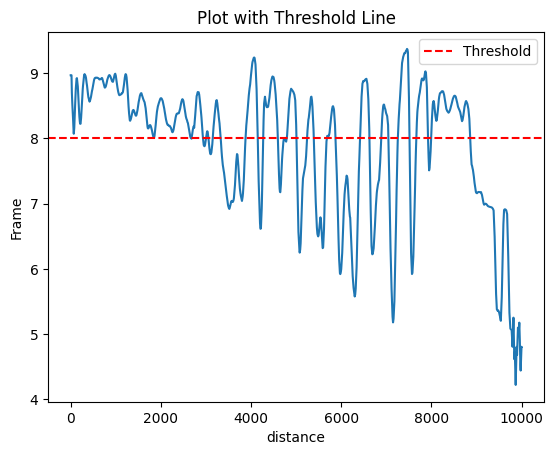

In [ ]:
time_points = np.arange(0, int(run_time/timestep), 1)
plt.plot(time_points,distances_sma_hist )
# Add a threshold line
threshold = 8
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

# Add labels and legend
plt.xlabel('distance')
plt.ylabel('Frame')
plt.title('Plot with Threshold Line')
plt.legend()

# Show the plot
plt.show()

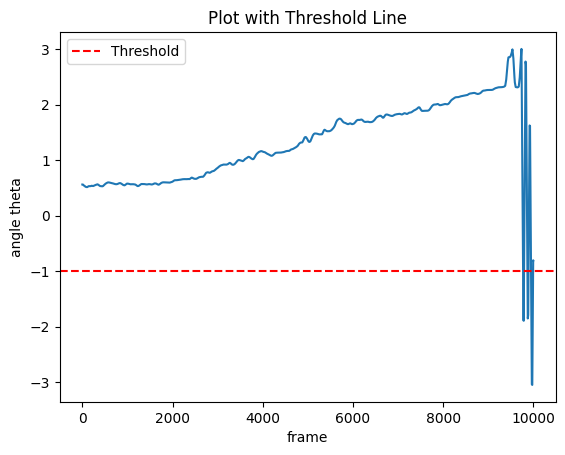

In [ ]:
plt.plot(time_points,theta_pred_sma_hist)
# Add a threshold line
threshold = -1
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

# Add labels and legend
plt.xlabel('frame')
plt.ylabel('angle theta')
plt.title('Plot with Threshold Line')
plt.legend()

# Show the plot
plt.show()

In [ ]:
theta_pred_history

deque([array([-2.99519863]),
       array([-2.99519863]),
       array([-2.99519863]),
       array([-2.99519863]),
       array([-2.99519863]),
       array([-2.99519863]),
       array([-2.99519863]),
       array([-2.99519863]),
       array([-2.99519863]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([-3.10448197]),
       array([2.58693648]),
       array([2.58693648]),
       array([2.58693648]),
       array([2.58693648]),
       array([2.58693648]),
       array([2.586

In [ ]:
x=[1,2,3,4]
y=[1,2,3,4]
pos = x,y

In [ ]:
pos

In [ ]:
# Function to calculate x and y coordinates given angle and distance
def calculate_trajectory(angle, distance):
    x = distance * np.cos(angle)  # Calculate x coordinate
    y = distance * np.sin(angle)  # Calculate y coordinate
    return x, y

position=[]
# Calculate trajectory for each combination of angle and distance
for i in range(len(theta_pred_sma_hist)):
    # Calculate trajectory
    position.append(calculate_trajectory(theta_pred_sma_hist[i], distances_sma_hist[i]))

    
# Show the plot
plt.plot(position[0], position[1])

NameError: name 'theta_pred_sma_hist' is not defined

In [ ]:
end_eff_x =  mid_leg_end_effector[:, 0, 0]
end_eff_y = mid_leg_end_effector[:, 0, 1]
end_eff_z = mid_leg_end_effector[:, 0, 2]

NameError: name 'mid_leg_end_effector' is not defined

In [ ]:
plt.plot(end_eff_x, end_eff_y, label='R End Effector')
plt.plot(end_eff_x, end_eff_z, label='R End Effector')
plt.plot(end_eff_y, end_eff_z, label='R End Effector')